In [4]:
import pandas as pd
import numpy as np
import scipy.io as sc
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt, figure
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA 

In [5]:
#import social factors
soc_df = pd.read_csv("datasets/after/mergedSOC.csv", index_col=0)
print(soc_df.shape)
soc_df.head()

(51, 336)


,00L13,01L13,02L13,03L13,04L13,05L13,06L13,07L13,08L13,09L13,...,38L19,39L19,40L19,41L19,42L19,43L19,44L19,45L19,46L19,47L19
county,,,,,,,,,,,,,,,,,,,,,
Angelina,8.8,6.8,48.6,19.6,16.3,7.4,14.5,29.6,26.6,6.1,...,28.7,55.5,1.3,3.6,10.9,23.0,51.3,2.9,6.8,16.0
Bastrop,3.1,8.3,50.9,20.1,17.6,10.3,10.1,31.0,24.5,6.6,...,36.0,47.3,1.1,2.2,13.5,27.4,43.3,1.0,11.3,17.0
Bell,5.6,5.5,41.7,16.9,30.3,4.4,4.1,30.2,28.3,10.2,...,33.7,51.8,2.4,2.3,9.8,31.6,45.4,2.1,7.7,13.2
Bexar,6.0,4.9,40.8,20.2,28.0,7.9,8.4,26.5,23.1,7.4,...,42.5,42.5,2.7,2.2,10.1,35.1,39.9,3.7,7.7,13.6
Bowie,1.8,5.8,49.0,23.7,19.6,2.4,9.7,38.2,25.9,5.1,...,32.7,46.2,2.2,3.8,15.2,25.3,48.8,2.5,10.5,12.9


In [6]:
#import hospital discharge data
hd_df = pd.read_csv("datasets/after/mergedIP.csv", index_col=0)
print(hd_df.shape)
hd_df.head()

(51, 28)


,1q13,2q13,3q13,4q13,1q14,2q14,3q14,4q14,1q15,2q15,...,3q17,4q17,1q18,2q18,3q18,4q18,1q19,2q19,3q19,4q19
county,,,,,,,,,,,,,,,,,,,,,
Angelina,3.565987,3.940571,3.754997,4.523638,3.707047,3.832749,3.903598,3.949308,3.908970,3.851704,...,4.003234,4.028282,4.154787,4.004243,4.089779,3.665519,4.223953,4.171425,4.397524,4.285616
Bastrop,0.130571,0.113250,0.091933,0.113250,0.098998,0.092309,0.073580,0.084282,0.098926,0.093650,...,0.047432,0.068651,0.062961,0.046010,0.008475,0.047221,0.049654,0.060294,0.043743,0.046107
Bell,3.785636,3.868283,3.815402,3.759353,3.287451,2.735081,2.534750,3.038192,2.975280,4.917622,...,3.887514,4.000583,3.889837,3.843808,3.747061,3.883680,3.748089,3.744923,3.692818,3.652228
Bexar,3.531182,3.486804,3.540411,3.524118,3.482455,3.460764,3.589123,3.596278,3.654202,3.573107,...,3.611293,3.698055,3.703316,3.632400,3.586749,3.685366,3.561545,3.581422,3.651632,3.656333
Bowie,7.351737,6.449875,6.636281,6.277476,6.476405,6.300118,6.694615,6.729012,6.863795,6.842376,...,6.917786,6.644815,6.440529,6.175073,6.398784,6.352757,6.438186,6.459586,6.438186,6.362216


# Autoregression to Predict 2019 Social Factors

### Insert Details

For the first part of our project, we decided to use an autoregressive model to predict social factors in 2019 using the previous years.  We then compared this to the actual social data from 2019.

In [7]:
# mergedSOC_df[[]]
mergedSOC_df = pd.read_csv("datasets/after/mergedSOC.csv", index_col=0)

In [8]:
# factors is an array of dataframes where factors[i] describes the i-th factor.
# For each dataframe, there are 51 rows (number of counties) and 7 columns (number of years)
factors = []
for i in range(0, 48):
    factors.append(mergedSOC_df[[]])

i = 0
for c in mergedSOC_df.columns:
    factors[i] = pd.concat([factors[i], mergedSOC_df.loc[:,c]], axis=1, join='inner')
    factors[i] = factors[i].rename(columns={c: c[-2:]})
    i = (i + 1) % 48


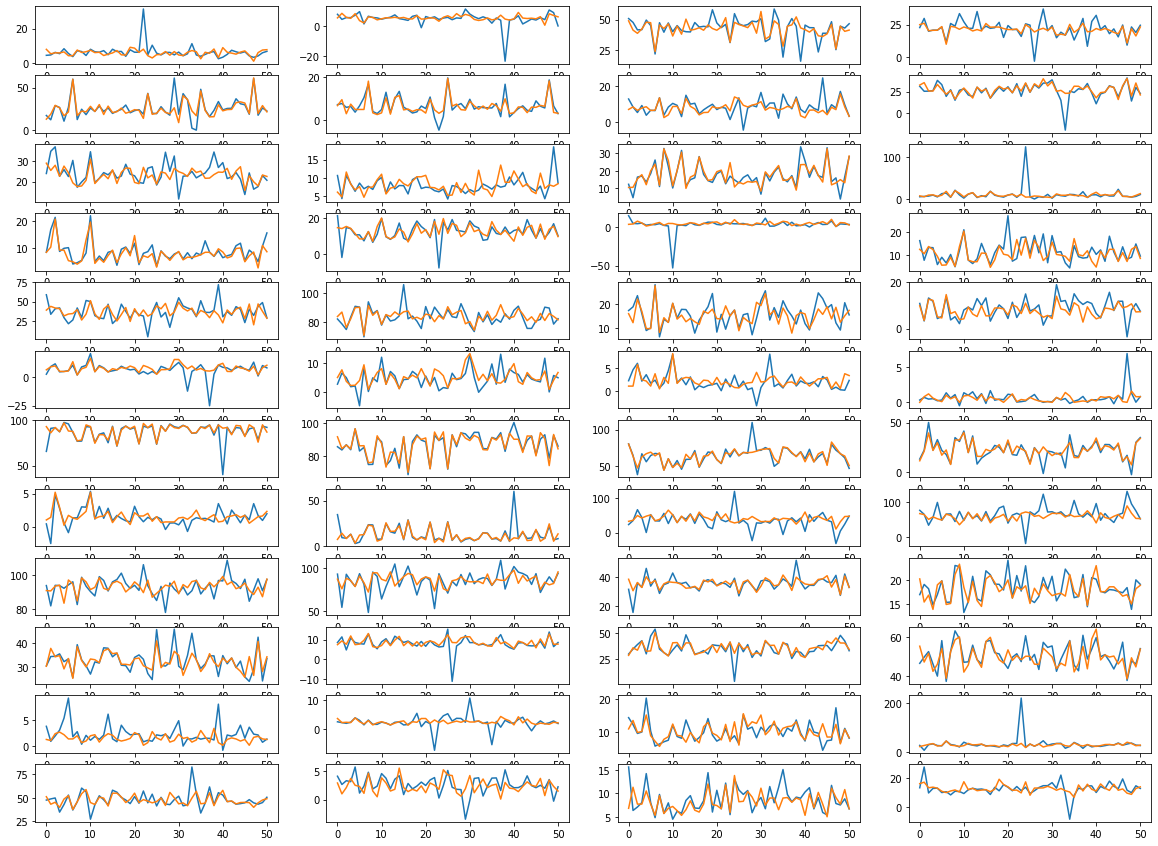

In [37]:
fig, axs = plt.subplots(12, 4, figsize=(20, 15))
row = 0
col = 0

for idx in range(48):
    #split test/train data
    test = factors[idx]["19"]
    train = factors[idx].drop("19", axis=1)
    test = np.array(test)
    train = np.array(train)
    predicts = []
    for i in range(51):
        model = AutoReg(train[i], lags = 2, old_names=False)
        fit_model = model.fit()
        predict = fit_model.predict(start = len(train[0,:]), end = len(train[0,:]), dynamic = False)
        predicts.append(predict)
        
    predicts = np.array(predicts)
    
    #visualize, calc error
    msqr = 1/len(test)*np.sum(test-predicts)**2
    rmsqr = msqr**(1/2)
    
    axs[row, col].plot(predicts)
    axs[row, col].plot(test)
    
    
    col = col + 1
    if (col == 4):
        row = row + 1
        col = 0
    # rmsqr

plt.show()

# Nonlinear vs Linear Neural Net

### Using Social Factors to predict Health Outcomes

For the next part of our project, we wanted to use our social factors to predict hospital discharges.  We first classified each county as "below average health", "average health", and "above average health" depending on the percentage of discharges they had relative to their population.

We then ran both a nonlinear neural network with sigmoid activation functions, and a linear network to compare how they functioned relative to one another.

Each model was run with social data from one year as inputs, and health outcome prediction (below, average, above) on the same respective year where below average health corresponds to an output of $100$, average to $110$ and above to $111$.

In [4]:
df_train_features = hd_df.groupby(np.arange(len(hd_df.columns))//4, axis=1).mean()
df_train_features.columns = ["2013", "2014", "2015", "2016", "2017", "2018", "2019"]
print(df_train_features.shape)
df_train_features.head()

(51, 7)


,2013,2014,2015,2016,2017,2018,2019
county,,,,,,,
Angelina,3.946298,3.848176,3.719706,3.689175,3.957975,3.978582,4.269630
Bastrop,0.112251,0.087292,0.080790,0.054672,0.054297,0.041167,0.049950
Bell,3.807168,2.898868,3.949127,3.852352,3.895622,3.841097,3.709514
Bexar,3.520629,3.532155,3.626351,3.593684,3.574073,3.651958,3.612733
Bowie,6.678842,6.550038,6.738760,6.456394,6.701773,6.341786,6.424544


In [5]:
#separate each year into its own df
df_train_labels_2013 = df_train_features.iloc[:, 0]
df_train_labels_2014 = df_train_features.iloc[:, 1]
df_train_labels_2015 = df_train_features.iloc[:, 2]
df_train_labels_2016 = df_train_features.iloc[:, 3]
df_train_labels_2017 = df_train_features.iloc[:, 4]
df_train_labels_2018 = df_train_features.iloc[:, 5]
df_train_labels_2019 = df_train_features.iloc[:, 6]

In [6]:
#calculate .33 quantile for each year
above_2013 = df_train_labels_2013.quantile(0.33)
above_2014 = df_train_labels_2014.quantile(0.33)
above_2015 = df_train_labels_2015.quantile(0.33)
above_2016 = df_train_labels_2016.quantile(0.33)
above_2017 = df_train_labels_2017.quantile(0.33)
above_2018 = df_train_labels_2018.quantile(0.33)
above_2019 = df_train_labels_2019.quantile(0.33)

In [7]:
#calculate .66 quantile for each year
average_2013 = df_train_labels_2013.quantile(0.66)
average_2014 = df_train_labels_2014.quantile(0.66)
average_2015 = df_train_labels_2015.quantile(0.66)
average_2016 = df_train_labels_2016.quantile(0.66)
average_2017 = df_train_labels_2017.quantile(0.66)
average_2018 = df_train_labels_2018.quantile(0.66)
average_2019 = df_train_labels_2019.quantile(0.66)

In [8]:
#calculate 1 quantile for each year
below_2013 = df_train_labels_2013.quantile(1)
below_2014 = df_train_labels_2014.quantile(1)
below_2015 = df_train_labels_2015.quantile(1)
below_2016 = df_train_labels_2016.quantile(1)
below_2017 = df_train_labels_2017.quantile(1)
below_2018 = df_train_labels_2018.quantile(1)
below_2019 = df_train_labels_2019.quantile(1)

In [9]:
df_test_features_2013 = soc_df.iloc[:, 0:48]
df_test_features_2014 = soc_df.iloc[:, 48:96]
df_test_features_2015 = soc_df.iloc[:, 96:144]
df_test_features_2016 = soc_df.iloc[:, 144:192]
df_test_features_2017 = soc_df.iloc[:, 192:240]
df_test_features_2018 = soc_df.iloc[:, 240:288]
df_test_features_2019 = soc_df.iloc[:, 288:336]
df_test_features_2013.head()

,00L13,01L13,02L13,03L13,04L13,05L13,06L13,07L13,08L13,09L13,...,38L13,39L13,40L13,41L13,42L13,43L13,44L13,45L13,46L13,47L13
county,,,,,,,,,,,,,,,,,,,,,
Angelina,8.8,6.8,48.6,19.6,16.3,7.4,14.5,29.6,26.6,6.1,...,28.3,51.7,3.5,3.8,12.7,23.7,47.4,4.3,11.6,13.0
Bastrop,3.1,8.3,50.9,20.1,17.6,10.3,10.1,31.0,24.5,6.6,...,29.0,55.5,2.4,3.7,9.4,24.0,51.6,1.7,9.2,13.5
Bell,5.6,5.5,41.7,16.9,30.3,4.4,4.1,30.2,28.3,10.2,...,35.6,50.1,3.0,2.6,8.8,29.1,47.2,1.8,8.0,13.9
Bexar,6.0,4.9,40.8,20.2,28.0,7.9,8.4,26.5,23.1,7.4,...,38.3,47.2,2.5,2.1,9.9,31.5,42.7,4.1,8.0,13.7
Bowie,1.8,5.8,49.0,23.7,19.6,2.4,9.7,38.2,25.9,5.1,...,33.8,45.7,2.3,2.8,15.5,26.5,45.5,4.9,10.1,13.0


In [10]:
# Combine all data into two data frames

# First rename all social factor columns to blank so they combine correctly
df_test_features_2013.columns = [''] * len(df_test_features_2013.columns)
df_test_features_2014.columns = [''] * len(df_test_features_2013.columns)
df_test_features_2015.columns = [''] * len(df_test_features_2013.columns)
df_test_features_2016.columns = [''] * len(df_test_features_2013.columns)
df_test_features_2017.columns = [''] * len(df_test_features_2013.columns)
df_test_features_2018.columns = [''] * len(df_test_features_2013.columns)
df_test_features_2019.columns = [''] * len(df_test_features_2013.columns)

# New df_Factors has all the info appended so years are staked on top of each other not in the same row
df_factors = df_test_features_2013.append(df_test_features_2014)
df_factors = df_factors.append(df_test_features_2015)
df_factors = df_factors.append(df_test_features_2016)
df_factors = df_factors.append(df_test_features_2017)
df_factors = df_factors.append(df_test_features_2018)
df_factors = df_factors.append(df_test_features_2019)

# New df_Labels has all the health data for the counties
labels = [df_train_labels_2013,df_train_labels_2014,df_train_labels_2015,df_train_labels_2016,df_train_labels_2017,df_train_labels_2018,df_train_labels_2019]
df_labels = pd.concat(labels)

In [11]:
train_x, test_x, train_y, test_y = train_test_split(df_factors,df_labels,test_size=0.2, random_state=10)

In [12]:
from sklearn.preprocessing import StandardScaler # scaling data may be important
scaler = StandardScaler()
scaler.fit(train_x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
NN = MLPRegressor(activation = 'logistic', solver = 'adam', max_iter = 10000)
NN.fit(train_x,train_y)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=105, learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [14]:
print(NN.score(test_x, test_y))
predicted = NN.predict(test_x)
#print(type(test_y), type(predicted))
p = pd.DataFrame(predicted)
p.index = test_y.index

0.5953544991945781


In [15]:
df_health_2013 = pd.concat([p, test_y.to_frame()], axis=1)
df_health_2013.columns = ['predicted', 'actual']
print(df_health_2013)
for i, row in df_health_2013.iterrows():
    ifor_val = i
    if i < above_2013:
        ifor_val = 'above'
    elif i < average_2013:
        ifor_val = 'average'
    elif i < below_2013:
        ifor_val = 'below'
    df_health_2013.at[i,'ifor'] = ifor_val
df_health_2013

            predicted    actual
county                         
Bowie        5.322184  6.701773
Victoria     4.446083  5.204733
Denton       2.230272  1.836167
Brazos       3.364395  3.391492
Henderson    1.831155  1.946129
Bastrop     -0.200432  0.087292
El Paso      3.294589  3.213816
Kaufman      0.835326  0.991011
Kaufman      1.246983  1.018507
Montgomery   3.292097  3.696732
El Paso      2.704352  3.244208
Dallas       3.431161  3.161687
Taylor       3.296528  5.370735
Angelina     4.798912  3.719706
Taylor       4.335393  5.163226
Brazoria     1.147881  0.573138
Hunt         3.751912  2.673692
Midland      3.490429  2.725634
Wichita      4.523888  4.349577
Angelina     3.142405  3.978582
Bexar        3.932042  3.612733
Denton       2.226424  1.681026
Randall      0.834554  0.010293
Bastrop      1.668416  0.112251
Harris       3.114009  3.227583
Walker       2.672878  1.746115
Nueces       4.867006  4.242944
Dallas       3.671803  3.120443
Midland      2.375984  2.463991
Bastrop 

TypeError: '<' not supported between instances of 'str' and 'float'

In [147]:
# randomly shuffles column x
x = 0
df_shuffled = np.random.permutation(df_factors.iloc[:,x].values)
df_temp = df_factors.copy()
df_temp.iloc[:,x] = df_shuffled

In [17]:
# scaling the data, haven't looked into exactly what this does but I saw that you should do this on some site
train_x, test_x, train_y, test_y = train_test_split(df_factors,df_labels,test_size=0.2, random_state=10)
scaler = StandardScaler()
scaler.fit(train_x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [25]:
for x in range(0,48): # computes an average score shuffling each column one by one and runing the program 25 times
    total = 0
    df_shuffled = np.random.permutation(df_factors.iloc[:,x].values)
    df_temp = df_factors.copy()
    df_temp.iloc[:,x] = df_shuffled
    for i in range(0, ):
        train_x, test_x, train_y, test_y = train_test_split(df_factors,df_labels,test_size=0.1, random_state=10)
        scaler.fit(train_x)
        NN.fit(train_x,train_y)
        total = total + NN.score(test_x, test_y)
    print (x)
    print (total/25)

0
0.7781656559100806
1
0.7417854626959999


No change
.73
0
0.7108650254858128
1
0.7960634235499481
2
0.8294445453849859
3
0.7131161077022256
4
0.7649890226507019
5
0.7182807190899667
6
0.770573975108926
7
0.7678379400275417
8
0.7394518440306926
9
0.7370813452666014
10
0.7469239702406627
11
0.6987987125400841
12
0.8031039579147157
13
0.7597713988573509
14
0.7407542084947817
15
0.7551527617051675
16
0.7032623511716416
17
0.7468654275975656
18
0.7269607583883346
19
0.7239341835447677
20
0.7063222378120773
21
0.7515546917564759
22
0.7811960516713465
23
0.7875212552563348
24
0.7701103826676152
25
0.8098780049975205
26
0.7555997194214767
27
0.6816149802794327
28
0.7656032470712896
29
0.7524800447927893
30
0.7565911712933635
31
0.6411801245922919
32
0.6958630774881265
33
0.707291988941758
34
0.7003487106236796
35
0.7880963245934186
36
0.6818116911936285
37
0.6882282528159364
38
0.755357675227565
39
0.7848156225992295
40
0.6928275829955649
41
0.7067307441389035
42
0.7815071724434892
43
0.673067085455601
44
0.7333788145720775
45
0.6352091856558159
46
0.6732250725388015
47
0.7716650884613394